In [1]:
%%capture
!pip install pandas
!pip install ruptures
!pip install numpy
!pip install matplotlib

!pip install saxpy
!pip install tsfresh
!pip install seaborn
!pip install sklearn
!pip3 install -U scikit-learn scipy matplotlib




# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates

from matplotlib import pyplot as plt

# package for feature training

# sklearn packages
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans


from sklearn.impute import SimpleImputer

%matplotlib inline



In [2]:
alldata = pd.read_csv("./CC_LCL-FullData_without_stdorToU.csv")
print('A sample of household IDs:', alldata.LCLid.unique()[:10])
household = "MAC000002"


df = alldata[alldata["LCLid"] == household ]
df.reset_index(drop=True, inplace=True)
import calendar


A sample of household IDs: ['MAC000002' 'MAC000003' 'MAC000004' 'MAC000006' 'MAC000007' 'MAC000008'
 'MAC000009' 'MAC000010' 'MAC000011' 'MAC000012']


In [3]:
import calendar

# Convert 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Assuming 'DateTime' is now a datetime column
df.loc[:, 'weekday'] = df['DateTime'].dt.day_name()

# Order the weekdays correctly
df.loc[:, 'weekday'] = pd.Categorical(df['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Assuming 'DateTime' is now a datetime column
df.loc[:, 'month'] = df['DateTime'].dt.month_name()

# Order the months correctly
df.loc[:, 'month'] = pd.Categorical(df['month'], categories=calendar.month_name[1:], ordered=True)



/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98246/1563538492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98246/1563538492.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'weekday'] = df['DateTime'].dt.day_name()
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_98246/1563538492.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [4]:
print('Earliest date:', df['DateTime'].min())
print('Latest date:', df['DateTime'].max())


Earliest date: 2012-10-12 00:30:00
Latest date: 2014-02-28 00:00:00


In [5]:
# set energy consumption data to numeric type
df = df[df["KWH/hh (per half hour) "] != "Null"]
df.loc[:,"energy"] = df["KWH/hh (per half hour) "].astype("float64")

# calculate the cumulative energy use over time for each date
df.loc[:,"cumulative_sum"] = df.groupby('DateTime')["energy"].cumsum()
df = df.set_index("DateTime")
df.head()

,LCLid,KWH/hh (per half hour),weekday,month,energy,cumulative_sum
DateTime,,,,,,
2012-10-12 00:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:30:00,MAC000002,0,Friday,October,0.0,0.0


<Axes: xlabel='DateTime'>

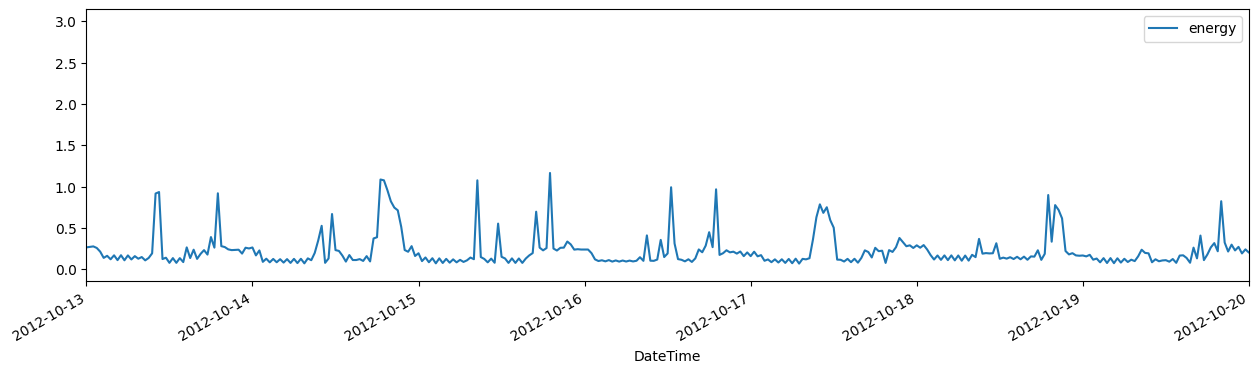

In [6]:
df.plot(y="energy", figsize=(15, 4), xlim=('2012-10-13', '2012-10-20'))


In [7]:
train_size = int(0.8 * len(df))
X_train, X_test = df[:train_size].index, df[train_size:].index
y_train, y_test = df[:train_size]["energy"].values, df[train_size:]["energy"].values

train_data = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, keys=["ds", "y"])
test_data = pd.concat([pd.Series(X_test), pd.Series([0]*len(y_test))], axis=1, keys=["ds", "y"])
answer_data = pd.concat([pd.Series(X_test), pd.Series(y_test)], axis=1, keys=["ds", "y"])

,LCLid,KWH/hh (per half hour),weekday,month,energy,cumulative_sum
DateTime,,,,,,
2012-10-12 00:30:00,MAC000002,0,Friday,October,0.000,0.000
2012-10-12 01:00:00,MAC000002,0,Friday,October,0.000,0.000
2012-10-12 01:30:00,MAC000002,0,Friday,October,0.000,0.000
2012-10-12 02:00:00,MAC000002,0,Friday,October,0.000,0.000
2012-10-12 02:30:00,MAC000002,0,Friday,October,0.000,0.000
...,...,...,...,...,...,...
2014-02-27 22:30:00,MAC000002,1.35,Thursday,February,1.350,1.350
2014-02-27 23:00:00,MAC000002,1.247,Thursday,February,1.247,1.247
2014-02-27 23:30:00,MAC000002,1.2180001,Thursday,February,1.218,1.218


In [44]:
from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly

train_data = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, keys=["ds", "y"])


model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_data)

17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:40 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(16022.416666666666, 16034.416666666666)

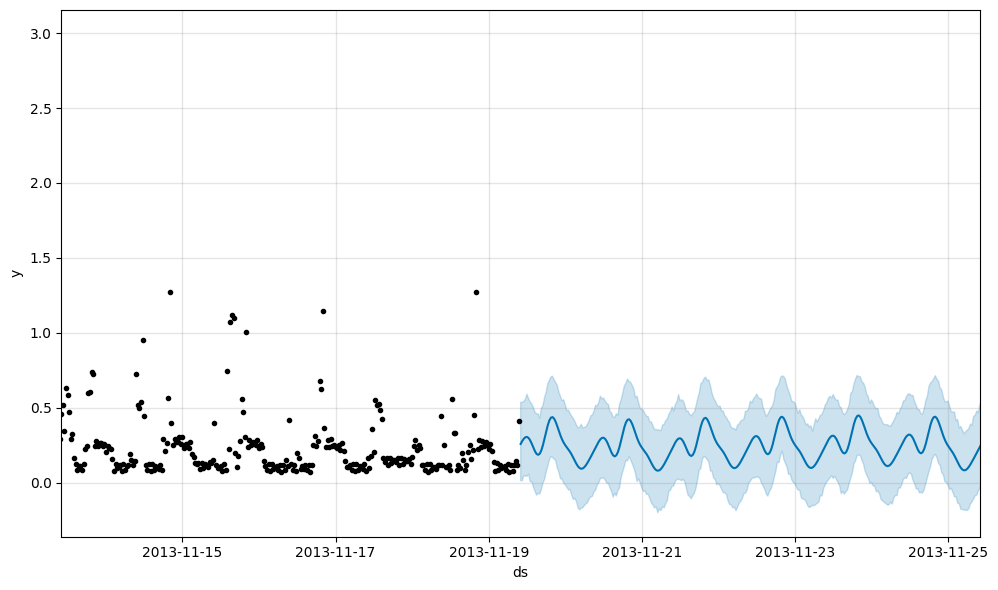

In [45]:
from datetime import timedelta

forecast = model.predict(test_data)
fig = model.plot(forecast)
forecast_start = test_data.ds[0]
axlim1 = forecast_start - timedelta(days=6)
axlim2 = forecast_start + timedelta(days=6)
plt.xlim(axlim1, axlim2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version thi

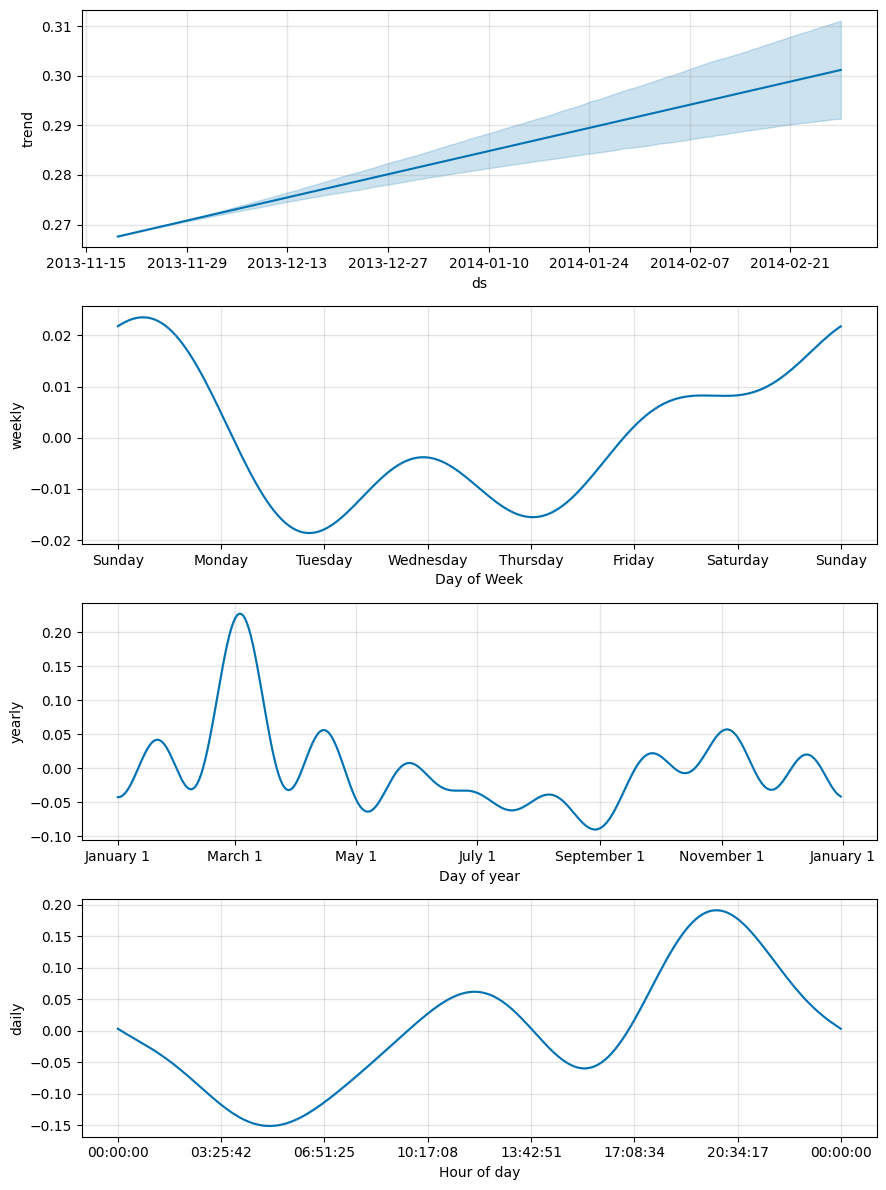

In [46]:
fig = model.plot_components(forecast)


In [47]:
df.reset_index(inplace=True)

df

ValueError: cannot insert level_0, already exists

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


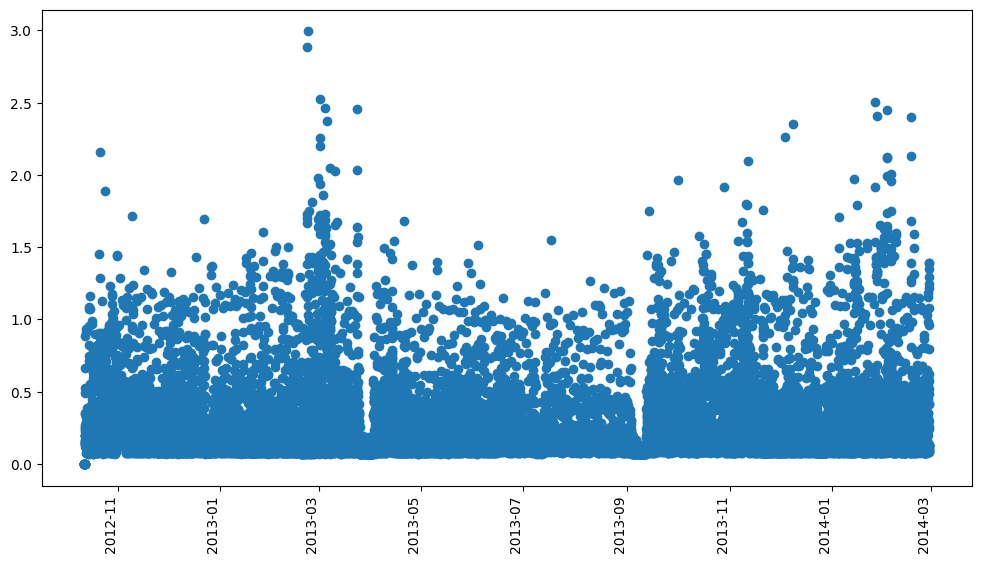

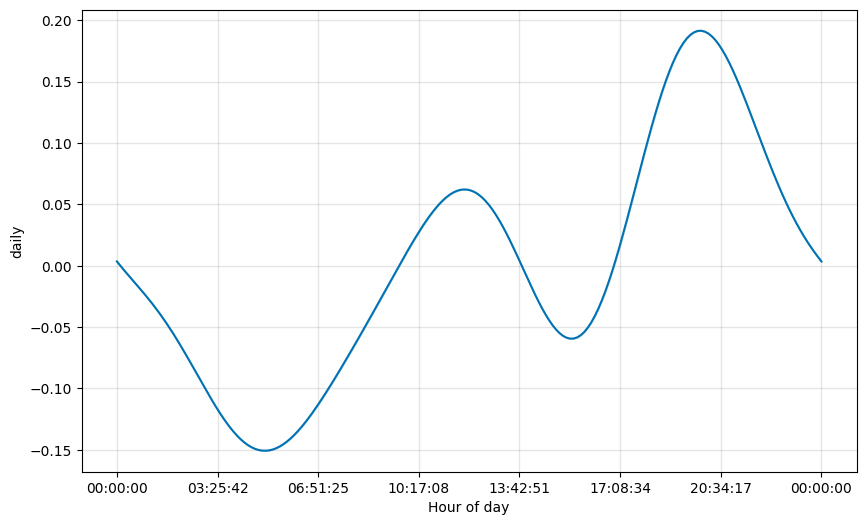

In [ ]:
fig, axs = plt.subplots(figsize=(12,7))
plt.scatter(x='DateTime', y='energy', data=df)
plt.gcf().autofmt_xdate(rotation=90)
fig.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

fig = plot_seasonality(model, 'daily')

In [ ]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_data)

17:11:17 - cmdstanpy - INFO - Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
df.groupby('weekday').mean().plot(y='energy', figsize=(10,6), title="Real energy use data mean")

plot_weekly(model, weekly_start=1)

TypeError: agg function failed [how->mean,dtype->object]